# Multi Time series
- This notebook is to demostrate how to handle multi time series (multi horizon) forecasting
    - LGBM (using multi-model approach from pervious notebook)
        - Show how different time series' scale/pattern/data imbalance affect the ML model: 
            - data balance (10 time series in same category with similar pattern) vs data imbalance (9 food vs 1 hobby)
            - No tranformation vs Standardization
        - Will exogenous features help ML model?
            - holiday, price
            - snap y[i], the whole time series x[1,w] + y[i]
    - DeepAR
    - N-BEATS

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

from plotting import Plot, ModelEvaluation
from time_series import TsHandler
from preprocess import Preprocessor, Dataset
from multi_horizon import Prediction
from config.get_config import ConfigHandler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read model_params from notebooks/config/model_params.yml
model_params = ConfigHandler.read_yml("model_params_path")

WINDOWSIZE = model_params['common']['windowsize']
HORIZON = model_params['common']['horizon']
LGBM_PARAMS = model_params['lgbm']['lgbm_params']
LGBM_TRAINER_ARGS = model_params['lgbm']['lgbm_trainer_args']

print(f"windowsize:{WINDOWSIZE}")
print(f"horizon:{HORIZON}")
print(f"lgbm_params:{LGBM_PARAMS}")
print(f"lgbm_trainer_args:{LGBM_TRAINER_ARGS}")

windowsize:12
horizon:28
lgbm_params:{'objective': 'l1', 'metric': 'rmse', 'learning_rate': 0.01}
lgbm_trainer_args:{'num_boost_round': 1000, 'early_stopping_rounds': 100, 'verbose_eval': 100}


In [3]:
df_sales = pd.read_csv('./data/sales_train_evaluation.csv')
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [4]:
# agg to item lvl for obtaining multi time series with obvious patterns
df = df_sales.drop(columns=[
    'id',
    # 'item_id', 
    'dept_id', 
    'cat_id', 
    'store_id', 
    'state_id'
    ])
df_item_id = df.groupby(['item_id']).sum()
df_item_id

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,...,7,8,8,4,7,7,5,7,5,9
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,...,5,8,7,2,6,5,0,6,6,4
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,...,7,8,6,11,9,7,7,10,6,5
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,115,104,107,81,73,62,71,75,83,93
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,...,15,16,25,9,7,25,19,25,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,5,4,1,3,2,4,2,8,7,5,...,5,7,11,4,8,3,4,5,4,7
HOUSEHOLD_2_513,0,0,0,0,0,0,0,0,0,0,...,4,0,5,3,6,3,0,9,3,4
HOUSEHOLD_2_514,4,8,2,1,1,2,3,8,2,1,...,2,2,2,6,1,0,1,4,3,3


In [5]:
# find the max of sum(sales) all over the time (~= more obvious pattern)
df_item_id.sum(axis=1).sort_values(ascending=False)

item_id
FOODS_3_090        1017916
FOODS_3_586         932236
FOODS_3_252         573723
FOODS_3_555         497881
FOODS_3_587         402159
                    ...   
HOBBIES_2_084          786
HOUSEHOLD_2_005        782
HOUSEHOLD_2_175        759
HOBBIES_2_119          673
HOUSEHOLD_2_101        593
Length: 3049, dtype: int64

In [6]:
# Show top 10 items
desc_index = df_item_id.sum(axis=1).sort_values(ascending=False).index[20:30]
df_top10 = df_item_id.reindex(desc_index)
df_top10

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_218,56,45,48,28,22,47,43,53,35,33,...,132,193,112,103,73,73,90,114,118,139
FOODS_3_376,77,69,63,95,55,88,101,105,76,106,...,78,144,124,99,76,89,79,85,116,88
FOODS_3_607,0,0,0,0,0,0,0,0,0,0,...,89,154,165,129,94,108,110,75,95,122
FOODS_3_099,0,0,0,0,0,0,0,0,0,108,...,82,134,125,96,100,81,79,84,118,134
FOODS_3_319,20,44,40,34,13,26,36,71,46,49,...,0,2,0,0,0,0,0,0,0,0
FOODS_3_295,125,122,77,68,59,92,87,136,105,140,...,107,139,256,113,120,119,90,103,118,151
FOODS_3_804,81,80,47,59,41,85,46,63,69,56,...,169,211,214,148,124,157,122,187,207,171
FOODS_3_752,103,148,232,154,64,93,147,192,149,146,...,114,129,80,75,38,87,75,79,129,165
FOODS_3_501,92,118,83,76,93,94,107,163,190,167,...,104,135,227,104,109,119,102,100,155,191


In [7]:
Plot.plot_multi_ts(df_top10)

# Multi time series
## Data Balance
- Selected the following item_id which has similar distribution -> kind of balanced data
- FOODS_3_: 252, 555, 714, 694, 226, 377, 080, 099, 804

In [8]:
names = ['FOODS_3_252', 'FOODS_3_555', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226', 'FOODS_3_377', 'FOODS_3_080', 'FOODS_3_099', 'FOODS_3_804']

Check the distribution of train set (if the data is balanced) for each time series

- Histogram

In [9]:
# select the names and plot the histograms of those ts within TRAIN period only
pivot = df_item_id[df_item_id.index.isin(names)].T.iloc[:-HORIZON].T
Plot.plot_histograms(pivot)

- Q-Q Plot: Is it normal distributed?

<img src=https://i.imgur.com/hRPny5B.png width="1000">

In [10]:
Plot.plot_qqplots(df_item_id, names)

### Multi Model Approach

---------------------Step1---------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 17109, number of used features: 12
[LightGBM] [Info] Start training from score 168.000000
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 37.965
[200]	valid_0's rmse: 27.8669
[300]	valid_0's rmse: 25.9635
[400]	valid_0's rmse: 25.696
[500]	valid_0's rmse: 25.6423
[600]	valid_0's rmse: 25.6294
[700]	valid_0's rmse: 25.5692
[800]	valid_0's rmse: 25.5123
[900]	valid_0's rmse: 25.5046
[1000]	valid_0's rmse: 25.4582
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 25.4582
---------------------Step2---------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can se

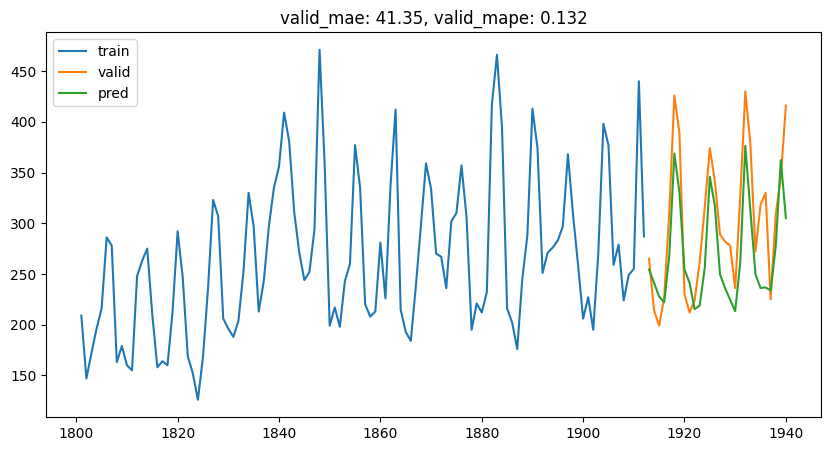


----------------------------------------------- FOODS_3_555 -----------------------------------------------


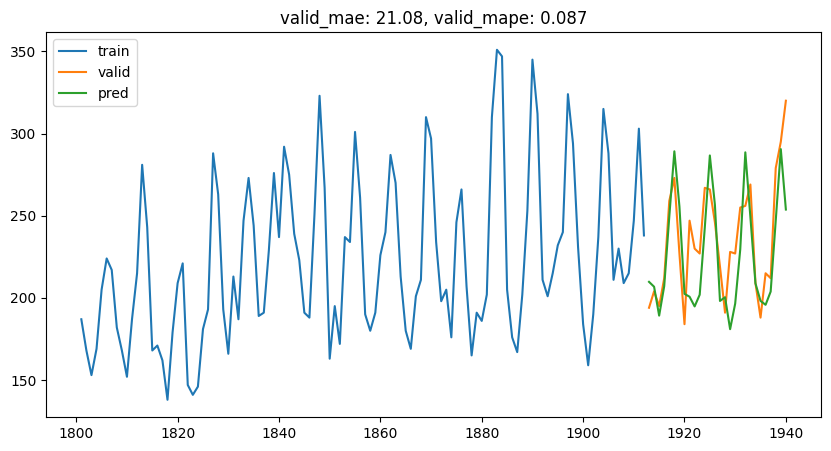


----------------------------------------------- FOODS_3_714 -----------------------------------------------


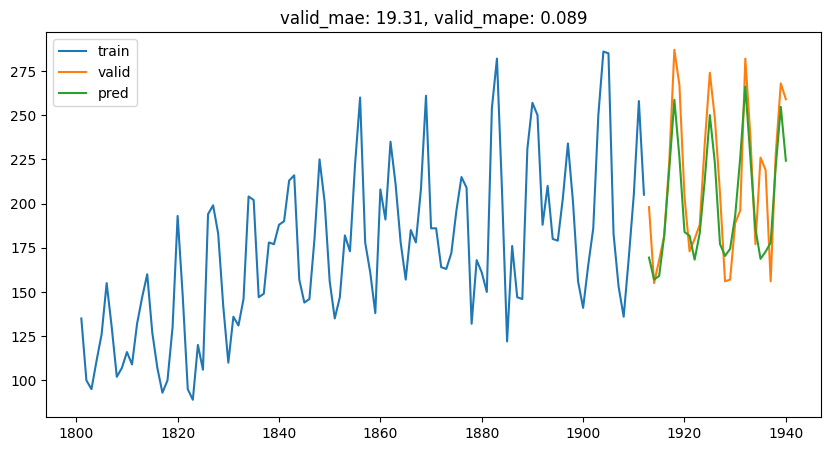


----------------------------------------------- FOODS_3_694 -----------------------------------------------


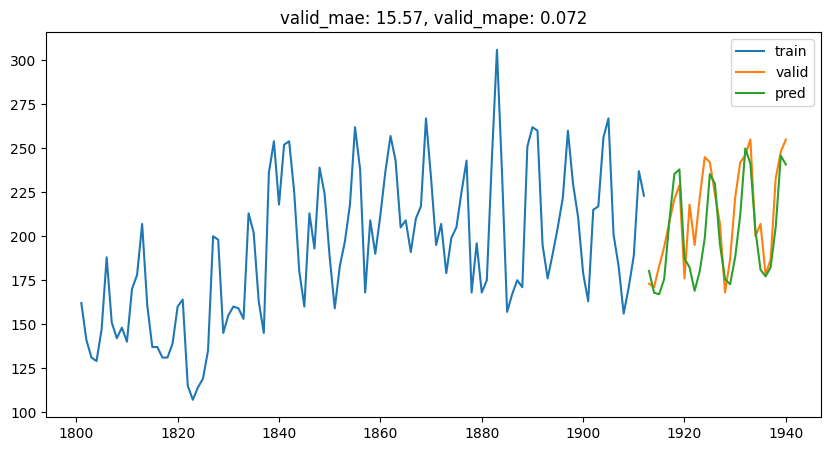


----------------------------------------------- FOODS_3_226 -----------------------------------------------


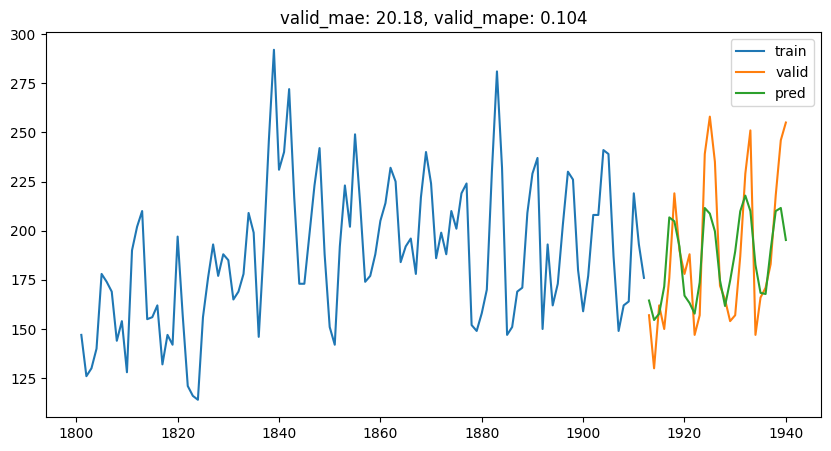


----------------------------------------------- FOODS_3_377 -----------------------------------------------


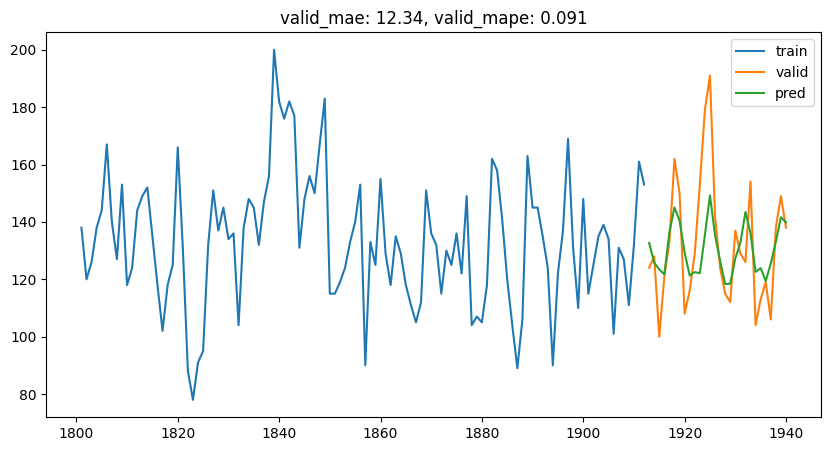


----------------------------------------------- FOODS_3_080 -----------------------------------------------


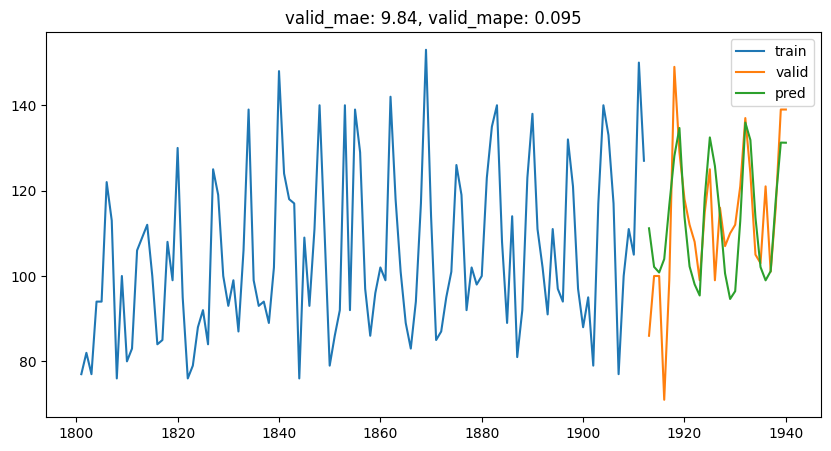


----------------------------------------------- FOODS_3_099 -----------------------------------------------


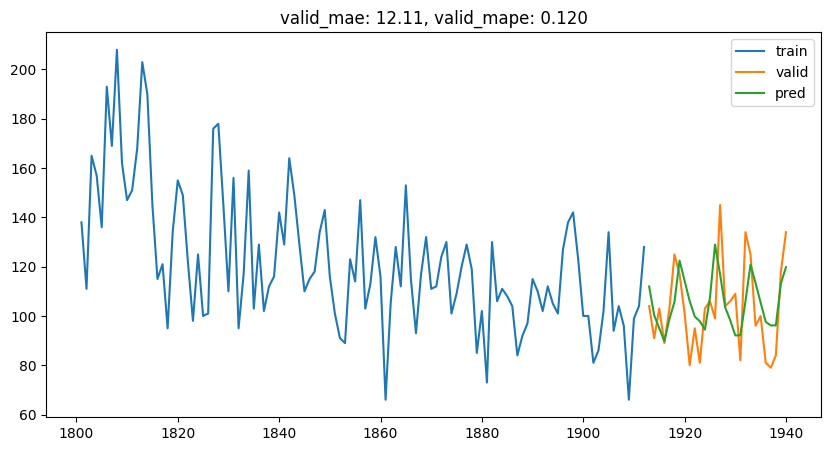


----------------------------------------------- FOODS_3_804 -----------------------------------------------


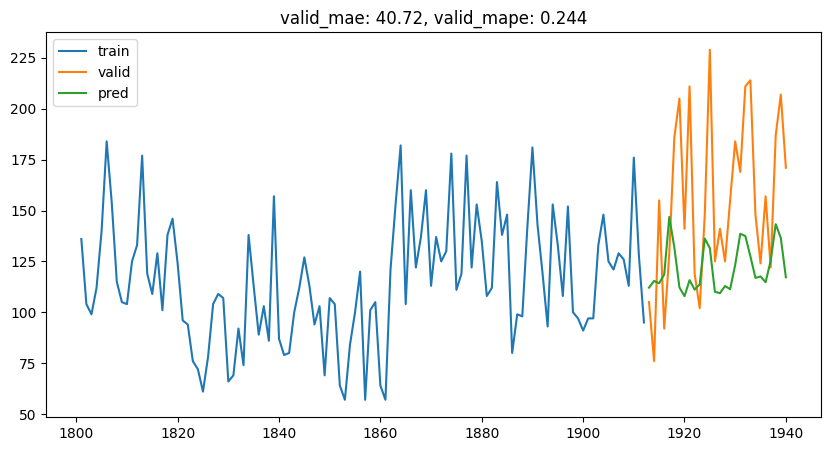

Overall mae: 21.38996953548133
Overall mape: 0.1149269067929477


In [14]:
df_y, df_y_pred, list_lgbm_model = Prediction.multi_model_approach(df_item_id, names, WINDOWSIZE, HORIZON, LGBM_PARAMS, LGBM_TRAINER_ARGS)

for i, name in enumerate(names):
    df_s = TsHandler.create_single_time_series(df_item_id, name=name)
    train = df_s.iloc[:-HORIZON]
    valid = df_s.iloc[-HORIZON:]
    y_pred = df_y_pred[name]
    print(f"\n----------------------------------------------- {name} -----------------------------------------------")
    valid_mae_lgbm, valid_mape_lgbm = Plot.plot_forecast(train.iloc[-HORIZON*4:], valid, y_pred)

# Overall mae & mape
print(f"Overall mae: {mae(df_y[names], df_y_pred[names])}")
print(f"Overall mape: {mape(df_y[names], df_y_pred[names])}")

---------------------Step1---------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 1901, number of used features: 12
[LightGBM] [Info] Start training from score 280.000000
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 45.9102
[200]	valid_0's rmse: 41.8997
[300]	valid_0's rmse: 41.2154
[400]	valid_0's rmse: 41.0982
Early stopping, best iteration is:
[358]	valid_0's rmse: 40.9704
---------------------Step2---------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 1900, number of used features: 12
[LightGBM] [Info] St

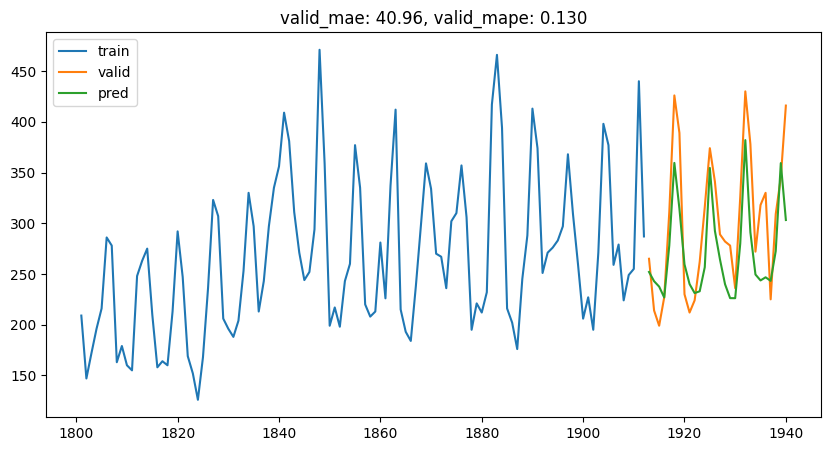

Overall mae: 40.96467854063009
Overall mape: 0.13012721482406833


In [15]:
# Compare result with single ts
names = ['FOODS_3_252']

df_y, df_y_pred, list_lgbm_model = Prediction.multi_model_approach(df_item_id, names, WINDOWSIZE, HORIZON, LGBM_PARAMS, LGBM_TRAINER_ARGS)

for i, name in enumerate(names):
    df_s = TsHandler.create_single_time_series(df_item_id, name=name)
    train = df_s.iloc[:-HORIZON]
    valid = df_s.iloc[-HORIZON:]
    y_pred = df_y_pred[name]
    print(f"\n----------------------------------------------- {name} -----------------------------------------------")
    valid_mae_lgbm, valid_mape_lgbm = Plot.plot_forecast(train.iloc[-HORIZON*4:], valid, y_pred)

# Overall mae & mape
print(f"Overall mae: {mae(df_y[names], df_y_pred[names])}")
print(f"Overall mape: {mape(df_y[names], df_y_pred[names])}")

- When data is balance, training with multi time series is similar to single time series.
- FOODS_3_252's valid mape: multi time series: 0.132 vs single time series: 0.130

## Data Imbalance
- Add 1 new item_id with different distribution on top of the balanced data
- Balanced: FOODS_3_: 252, 555, 714, 694, 226, 377, 080, 099, 804
- Imbalanced: 